Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
def Const(omega, x, sigma, mu, deriv, cellAve):
    degFreed = omega.degFreed
    k = 1
    ct = 0
    
    fact = 2.0 * np.pi * k
    u = np.arange(degFreed)# (1.0 / fact) * (cos(fact * (x[:-1] - ct)) - cos(fact * (x[1:] - ct)))
    return u

In [3]:
nh_min = 32
refRatio = 2
CFL = 0.5 # np.sqrt(0.5)
nt = int(5 * nh_min / 2) # 1
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 4
order = 4

L = 1
locs = [x_1]
epsilons = [0.5, 0.2] # [0.5, 0.5] # [1, 1]
mus = [0.5, 0.2] # [0.5, 0.5] # [1, 1]

func = WFT.GaussPacket
mode = 23

In [4]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

In [5]:

physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
cAMR = physicsAMR.cVec
cMatAMR = physicsAMR.cMat

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat

c = cC[0]

In [6]:
def ExpandMat(mat):
    errorLoc = 'ERROR:\nOperatorTools:\nExpandMat:\n' # Don't know where we're putting this yet.
    errorMess = ''
    shape = np.shape(mat)
    if (len(shape) != 2):
        errorMess = 'mat must be a rank-2 matrix!'
    
    else:
        if (shape[0] != shape[1]):
            errorMess = 'mat must be a square matrix!'
    if (errorMess != ''):
        sys.exit(errorLoc + errorMess)
    
    size_min = shape[0]
    size_max = 2 * size_min
    newMat = np.zeros((size_max, size_max), int)
    newMat[0:size_max:2, 0:size_max:2] = mat
    newMat[1:size_max + 1:2, 1:size_max + 1:2] = mat
    return newMat

In [7]:
# Creates anti-block-diagonal matrix 
def ConvertOp(omega, physics):
    degFreed = omega.degFreed
    cMat = physics.cMat
    cVec = physics.cVec
    c1 = cVec[0]
    c2 = cVec[-1]
    
    bacCoefs = np.zeros(degFreed, float)
    forCoefs = np.ones(degFreed, float)
    bacCoefsInv = np.zeros(degFreed, float)
    forCoefsInv = np.ones(degFreed, float)
    
    cVecs = np.asarray(np.append(cVec, -cVec))
    
    # eigVals = #[item for sublist in zip(cVec, -cVec) for item in sublist]
    I = np.eye(degFreed)
    normConst = 0.5 #  / np.sqrt(c**2 + 1)
    op = normConst * np.asarray(np.block([[cMat, cMat], [-I, I]]))
    diagMat = np.diag(cVecs)
    
    RCoef = (2. * c1) / (c1 + c2)
    TCoef = -(c1 - c2) / (c1 + c2)
    
    bacCoefs[cVec == c1] = RCoef
    forCoefs[cVec == c2] = TCoef
    
    bacCoefsInv[cVec == c1] = 1. / RCoef
    forCoefsInv[cVec == c2] = 1. / TCoef
    
    Coefs = np.asarray(np.append(bacCoefs, forCoefs))
    CoefsInv = np.asarray(np.append(bacCoefsInv, forCoefsInv))
    
    CoefOp = np.diag(Coefs) # np.eye(2 * degFreed) # 
    CoefOpInv = np.diag(Coefs)

    return op, diagMat, CoefOp, CoefOpInv

In [8]:
A, B, C, D = ConvertOp(omegaC, physicsC)

If  
$v_{j}^{s} = \frac{E_{j}^{s} - c B_{j}^{s}} {2 c}$  
and  
$v_{n + j}^{s} = \frac{E_{j}^{s} + c B_{j}^{s}}{2 c}$  
and  
$B_{j}^{0} = \frac{E_{j}^{0}}{c}$,  
then  
$c \Delta t \frac{\partial v_{j}^{0}}{\partial x} = 0$  
and  
$c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x} = \frac{\sigma_{CFL}}{c} (E_{j}^{0} - E_{j - 1}^{0})$.  
  
If  
$v_{j}^{1} = v_{j}^{0} + c \Delta t \frac{\partial v_{j}^{0}}{\partial x}$  
and  
$v_{n + j}^{1} = v_{n + j}^{0} - c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x}$,  
then  
$v_{j}^{1} = 0$  
and  
$v_{n + j}^{1} = \frac{1}{c} [(1 - \sigma_{CFL}) E_{j}^{0} + \sigma_{CFL} E_{j - 1}^{0}]$. 
  
If  
$E_{j}^{s} = c (v_{j}^{s} + v_{n + j}^{s})$  
and  
$B_{j}^{s} = v_{n + j}^{s} - v_{j}^{s}$,  
then  
$E_{j}^{1} = E_{j}^{0} - \sigma_{CFL} (E_{j}^{0} - E_{j - 1}^{0})$  
and  
$B_{j}^{1} = \frac{1}{c} [E_{j}^{0} - \sigma_{CFL} (E_{j}^{0} - E_{j - 1}^{0})] = B_{j}^{0} - \sigma_{CFL} (B_{j}^{0} - B_{j - 1}^{0})$.  


In [9]:
def Check(omega, physics, CFL, u0stack, v_i, v_f, u_f, op):
    
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    c = physics.cVec[0]
    cMat = physics.cMat
    roundFact = 15
    
    I = np.eye(degFreed)
    dx, dt = ST.FindDxDt(omega, CFL, cMat)
    print('')
    print('')
    print('After 1 Forward Euler timestep on a uniform grid:')
    print('')
    print('The derivative of v should be')
    uShiftM = np.roll(u0stack, 1)
    uShiftP = np.roll(u0stack, -1)
    alpha_min = (1. - c) / (2 * c)
    alpha_plu = (1. + c) / (2 * c)
    derivShould1 = np.zeros(degFreed, float)
    derivShould2 = CFL * (uShiftM - u0stack) # The factor of c is already embedded within u0stack!!!
    derivShould = np.round(np.asarray(np.append(derivShould1[:degFreed], derivShould2[degFreed:])), roundFact)
    print(derivShould)
    print('In actuality, it is')
    derivres = np.round(dt * op @ v_i, roundFact)
    print(derivres)
    print('This is off by a factor of')
    r1 = np.round([derivShould[i] / derivres[i] for i in range(len(derivres))], 12)
    r1[derivShould == derivres] = 1
    print(r1)
    indices1 = np.where(r1 != 1)
    print('Indices:', indices1[0])
    print('Factors:', r1[indices1[0]])
    print('')
    print('v itself should be')
    shouldbe1 = np.zeros(degFreed, float) # alpha_min * (((1. - CFL) * u0stack) + (CFL * uShiftP))
    shouldbe2 = ((1. - CFL) * u0stack) + (CFL * uShiftM) # The factor of c is already embedded within u0stack!!!
    shouldbe = np.round(np.asarray(np.append(shouldbe1[:degFreed], shouldbe2[degFreed:])), roundFact)
    print(shouldbe)
    print('In actuality, it is')
    v_f1 = np.round(v_f, roundFact)
    print(v_f1)
    print('This is off by a factor of')
    r = np.round([shouldbe[i] / v_f1[i] for i in range(len(v_f))], roundFact)
    r[shouldbe == v_f1] = 1
    print(r)
    indices = np.where(r != 1)
    print('Indices:', indices[0])
    print('Factors:', r[indices[0]])
    print('')
    print('u should be')
    u1 = ((1. - CFL) * u0stack) + (CFL * uShiftM) # The factor of c is already embedded within u0stack!!!

    u = np.round(u1, roundFact)
    print(u)
    print('In actuality, it is')
    u_f1 = np.round(u_f, roundFact)
    print(u_f1)
    print('This is off by a factor of')
    r2 = np.round([u[i] / u_f1[i] for i in range(len(u_f))], roundFact)
    r2[u == u_f1] = 1
    print(r2)
    indices2 = np.where(r2 != 1)
    print('Indices:', indices2[0])
    print('Factors:', r2[indices2[0]])
    return

In [10]:
def AdvectRK(omega, physics, u0, nt, CFL, RK, deriv, order):
    
    errorLoc = 'ERROR:\nSolverTools:\nAdvectRK:\n'
    errorMess = ''
    
    dt, cMat, waves, derivOp, Scheme = RKPieces(omega, physics, CFL, RK, deriv, order, 1)
    
#     if (order != 0):
#         if (func != TimePoly):
#             print('Spatial derivative method has been overridden in favor of TimePoly()!')
#         func = TimePoly # CHANGE THIS PROBABLY! AND FOR ALL THE OTHER RKS!
    
    u = u0.copy()
    t = 0
    for n in range(nt):
        u, t = Scheme(u, t, dt, op, waves, left)
    uCoefs = LA.inv(waves) @ u
    return uCoefs

In [11]:
def RKPieces(omega, physics, CFL, RK, deriv, order, PDEOrder):
    
    errorLoc = 'ERROR:\nSolverTools:\nRKPieces:\n'
    errorMess = ''
    matInd = physics.matInd
    
    if (deriv == 'Fourier'):
        left = False
        derivOp1 = OT.ExactSpatDerivOp(omega)
        derivOp2 = derivOp1
    else:
        left = True
        if (deriv == 'U' or deriv == 'UD'):
            derivOp1 = OT.SpaceDeriv(omega, order, deriv, matInd)
            derivOp2 = OT.SpaceDeriv(omega, order, 'D', matInd)
        else:
            if (deriv == 'D' or deriv == 'DD'):
                derivOp1 = OT.SpaceDeriv(omega, order, 'U', matInd)
                derivOp2 = OT.SpaceDeriv(omega, order, deriv, matInd)
            else:
                derivOp1 = OT.SpaceDeriv(omega, order, deriv, matInd)
                derivOp2 = derivOp1
    
    if (RK == 1):
        Scheme = ST.ForwardEuler
    else:
        if (RK == 2):
            Scheme = ST.MidpointMeth
        else:
            if (RK == 4):
                Scheme = ST.RK4
            else:
                errorMess = str(RK) + ' is not a valid RK entry!'
    
    cMat1 = physics.cMat
    dx, dt = ST.FindDxDt(omega, CFL, cMat1)
    waves1 = WT.MakeWaves(omega)
    nullspace = OT.FindNullspace(omega, waves1)
    
    
    if (PDEOrder == 1):
        derivOp == derivOp1
        waves = waves1 @ nullspace
        cMat = cMat1
    else:
        if (PDEOrder == 2):
            derivOp = OT.Block([derivOp1, derivOp2])
            waves = OT.Block(waves1 @ nullspace, var = 2)
            cMat = OT.Block(cMat1, var = 2)
        else:
            errorMess = 'Invalid PDE order!'
    print('matInd:', matInd)
    B = derivOp + 0
    B[B != 0] = 1
    print('derivOp:\n', B)
    
    if (errorMess != ''):
        sys.exit(errorLoc + errorMess)
    
    return dt, cMat, waves, derivOp, Scheme, left

In [12]:
#   WaveEqRK(omega, physics, waves, u0, nt, CFL, RK, deriv) deriv will be upwind, center, or exact.
def WaveEqRK(omega, physics, u0, nt, CFL, RK, deriv, order): # derivOp, left = True):
    
    errorLoc = 'ERROR:\nSolverTools:\nWaveEqRK:\n'
    errorMess = ''

    dt, cMat, waves, derivOp, Scheme, left = RKPieces(omega, physics, CFL, RK, deriv, order, 2)
    
    # Unpack requisite attributes.
    degFreed = omega.degFreed
    
    c = cMat[0, 0]
    
    # Stack the initial condition.
    u0stack = np.asarray(np.append(u0, u0 / c)) # I'm not sure how to relate the initial condition for the E and B fields.
    
    # Create change of basis matrix.
    convertOp, diagMat, coefOp, coefOpInv = ConvertOp(omega, physics)
    convertOpinv = LA.inv(convertOp)
    
    # Change basis of initial condtion.
    v0 = np.asarray(coefOp @ convertOpinv @ u0stack)
    v = v0.copy()
    
    # Create identity matrix to appease the current structure of my RK function.
    I = np.eye(2 * degFreed)
    
    # Create operator to pass into RK function.
    op = diagMat @ derivOp
    
    t = 0
    for n in range(nt):
        v, t = Scheme(v, t, dt, op, waves, left)

#     for i in range(nt):
#         #   ST.RungeKutta(omega, physics, waves, u0, nt, CFL, RK, op = [], left = True)
#         v = ST.RungeKutta(omega, physics, I, v, 1, CFL, RK, op = op)
    
    # Convert v back to space-space.
    u = convertOp @ coefOpInv @ v

    # Convert u to k space.
    fCoefs = LA.inv(waves) @ u
    
    # Run check.
    if ((nt == 1) and (RK == 1)):
        Check(omega, physics, CFL, u0stack, v_i, v, u, op)
    
    return fCoefs, v


In [13]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)
mu, sigma = WFT.GaussParams(x_0, x_1)
args = [mu, sigma, mode]
wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)


In [14]:
# wavesAMR = OT.Block(wavesAMR, var = 2)
# nullspace = OT.Block(nullspace, var = 2)
# restrictOp = OT.Block(restrictOp, var = 2)
# wavesC = OT.Block(wavesC, var = 2)
# wavesF = OT.Block(wavesF, var = 2)

opC = OT.SpaceDeriv(omegaC, order, deriv)#-cMatC @ OT.SpaceDeriv(omegaC, order, diff)
opF = OT.SpaceDeriv(omegaF, order, deriv)#-cMatF @ OT.SpaceDeriv(omegaF, order, diff)
opAMR = OT.SpaceDeriv(omegaAMR, order, deriv)#-cMatAMR @ OT.SpaceDeriv(omegaAMR, order, diff)

hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)


In [15]:
waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
waveInitF = WFT.InitCond(omegaF, physicsF, func, args)

FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsC1 = np.asarray(np.append(FCoefsC, FCoefsC / c))
FCoefsF1 = np.asarray(np.append(FCoefsF, FCoefsF / c))

# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
FCoefsAMR1 = np.asarray(np.append(FCoefsAMR, FCoefsAMR / c))

wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC
wavePropF = WFT.WaveEq(omegaF, physicsF, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsAMR, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)
FCoefsPropC1 = np.asarray(np.append(FCoefsPropC, FCoefsPropC / c))
FCoefsPropF1 = np.asarray(np.append(FCoefsPropF, FCoefsPropF / c))
FCoefsPropAMR1 = np.asarray(np.append(FCoefsPropAMR, FCoefsPropAMR / c))

# TEST FOR EXACT GAUSSIAN AT NEW LOCATION.

# solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
# solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, op = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
# solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, op = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

solverCoefsC, vC = WaveEqRK(omegaC, physicsC, waveInitC, nt, CFL, RK, deriv, order) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF, vF = WaveEqRK(omegaF, physicsF, waveInitF, nt, CFL, RK, deriv, order) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR, vAMR = WaveEqRK(omegaAMR, physicsAMR, waveInitAMR, nt, CFL, RK, deriv, order) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)


allCoefsC = PT.Load(FCoefsC1, FCoefsPropC1, solverCoefsC)#, doubleSolvCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF1, FCoefsPropF1, solverCoefsF)#, FCoefsPropFTh)
# allCoefsAMR = nullspace @ PT.Load(FCoefsAMR1, FCoefsPropAMR1, solverCoefsAMR)#, FCoefsPropAMRTh)




labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']#, 'Naively RK-Propagated Wave']#, 'Rotation Matrix Propagated Wave']


We're doing BoolesAve!
x is 129 long.
We're doing BoolesAve!
x is 257 long.
We're doing BoolesAve!
x is 129 long.
We're doing BoolesAve!
x is 257 long.
We're doing BoolesAve!
x is 193 long.
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 16
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hIn

 [[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds are: [0.5     0.53125 0.5625  0.59375 0.625   0.65625] <= 0.5
hInv: (5, 5)
A: (5, 5)
B: (5, 5)
polyCoefs: (5, 5)
matInd is 32
this one.
Bounds 

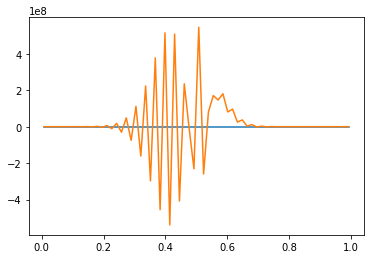

In [16]:
xF = omegaF.xCell
plt.figure()
plt.plot(xF, vF[:nh_max])
plt.plot(xF, vF[nh_max:])
plt.show()

Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/FineE.
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/FineEB.


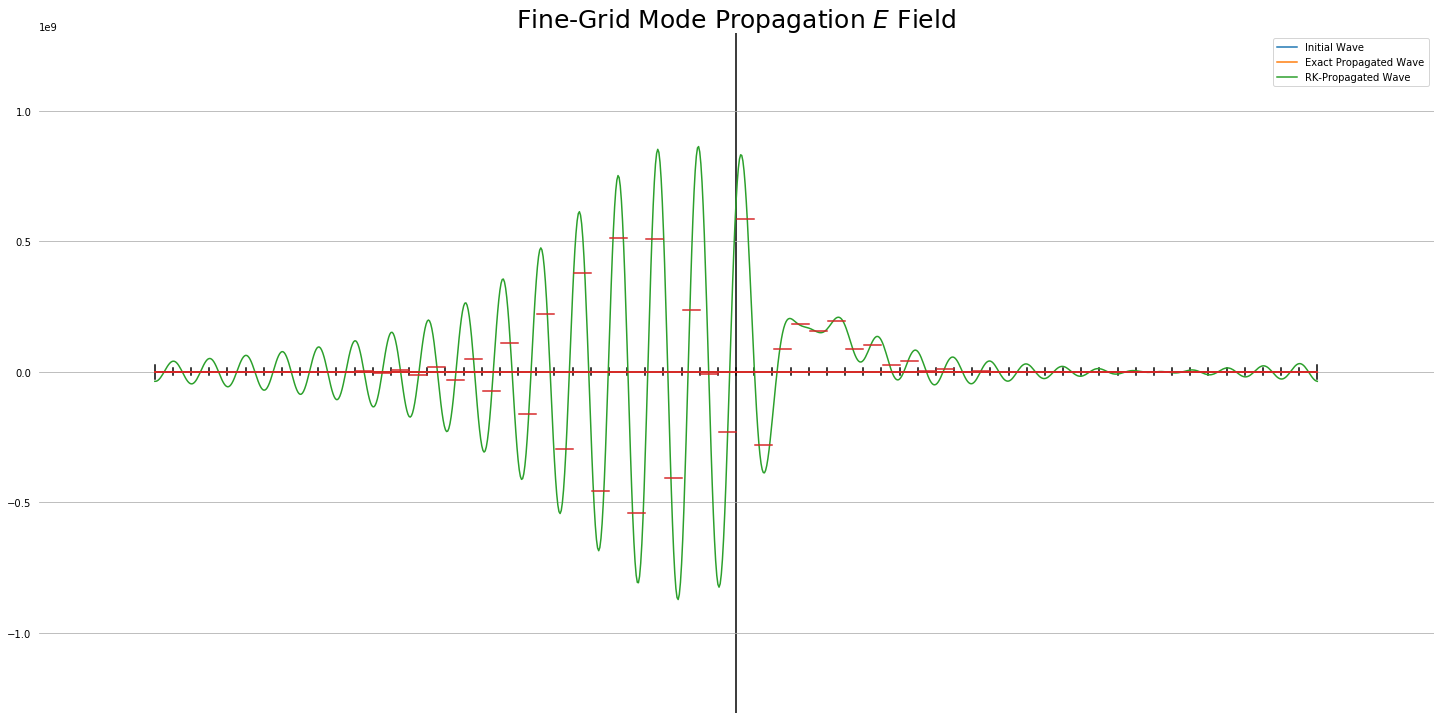

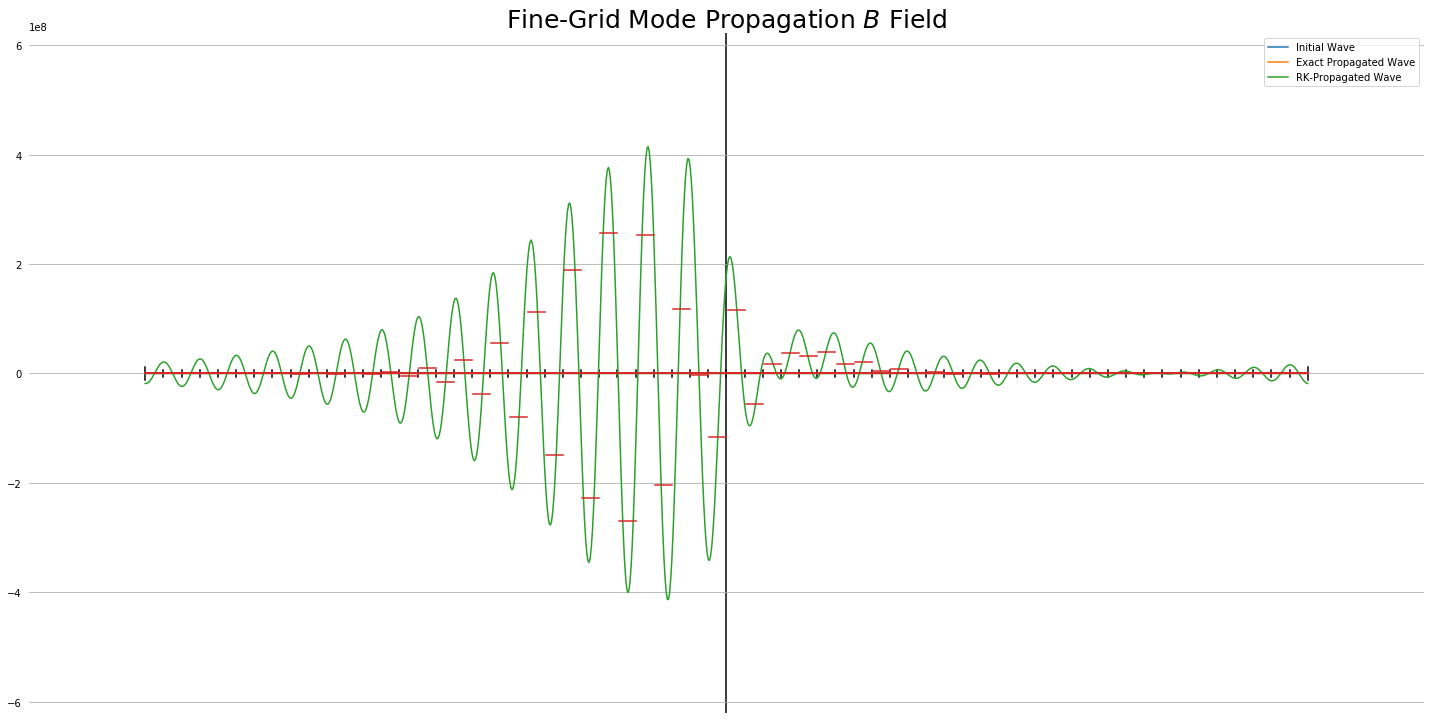

In [17]:
# PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, saveName = 'RKWaveEqAttemptc2')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
# PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [18]:
func = WFT.Gauss
args = [mu, sigma]
nt = 1
dataPts = 8
errorE = np.zeros(dataPts, float)
errorB = np.zeros(dataPts, float)
nhPower = np.arange(dataPts) + 1
nhVec = 4 * (2 ** nhPower)
print(nhVec)
print('')

labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']
for i in range(dataPts):
    
    print('iter', i)
    nh_min = 2 ** (i + 3)
    print(nh_min)
    omega = BT.Grid(nh_min)
    physics = BT.PhysProps(omega, epsilons, mus, locs, L)

    c = physics.cVec
    cMat = physics.cMat
    c = c[0]

    t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt)
    waves = WT.MakeWaves(omega)
    wavesMat = OT.Block(waves, var = 2)
    op = OT.SpaceDeriv(omega, order, deriv)

    waveInit = WFT.InitCond(omega, physics, func, args)
    FCoefs = FFTT.FourierCoefs(waves, waveInit)
    FCoefs1 = np.asarray(np.append(FCoefs, FCoefs / c))

    waveProp = WFT.WaveEq(omega, physics, func, args, t)
    wavePropEx = np.asarray(np.append(waveProp, waveProp / c))

    # Find propagated coeficients on coarse and fine grid.
    FCoefsProp = FFTT.FourierCoefs(waves, waveProp)
    FCoefsProp1 = np.asarray(np.append(FCoefsProp, FCoefsProp / c))

    solverCoefs, v = WaveEqRK(omega, physics, waveInit, nt, CFL, RK, deriv, order)
    wavePropSolv = wavesMat @ solverCoefs

    errorVec = abs(wavePropEx - wavePropSolv)
    errorE[i] = TT.VectorNorm(errorVec[:nh_min], 'max')
    errorB[i] = TT.VectorNorm(errorVec[nh_min:], 'max')
    
    allCoefs = PT.Load(FCoefs1, FCoefsProp1, solverCoefs)
#     PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels)
    
    print('')

print('done')


[   8   16   32   64  128  256  512 1024]

iter 0
8
matInd is 4
this one.
Bounds are: [0.5   0.625 0.75  0.875 1.   ] <= 0.5
hInv: (4, 4)
A: (4, 4)
B: (4, 4)
polyCoefs: (5, 5)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 4)

In [ ]:
plt.figure()
plt.plot(nhVec, errorE)
plt.title(r'$E$ Field Error')
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(nhVec, errorB)
plt.title(r'$B$ Field Error')
plt.ylabel('Max Norm Error')
plt.xlabel('Resolution')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.
# I see that I can't use the rotation matrix to propagate the matrices. I'm pretty sure that my Fourier-propagated logic is wrong, though.
# 2nd-order polynomial interp is working BETTER THAN 3rd-order for RK4 center diff.
# How do I employ Fourier transforms on Maxwell's Equations?


In [ ]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.


In [ ]:
A = np.arange(10)
print(A)
print(A[-1])
print('')